# Data Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sea
import geodatasets as gds
import fiona #geopandas needs this for shapefiles
from geopy.distance import geodesic
from matplotlib import colormaps
from shapely.geometry import Point

pd.set_option('display.max_columns', 70) # Set max display to 70 columns
pd.set_option('display.float_format', '{:.0f}'.format) #Causes pandas do NOT output integers as exponents

/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Importing the 2022 Utah crime data from the [Utah crime data](https://bci.utah.gov/crime-in-utah-2022/) website, as well as [municipality](https://gis.utah.gov/products/sgid/boundaries/municipal/) and [census tract](https://gis.utah.gov/products/sgid/demographic/census-2020-tracts/) data to join on county or municipality FIPS:

In [ ]:
crime_df = pd.read_csv("2022crime.csv") #create Crime data dataframe
uninsured_df = pd.read_csv("2020uninsured.csv") #create Uninsured data dataframe

#CENSUS TRACT BASEMAP (which has GEOID20 as well as county FIPS)
utct_base = r"/Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/CensusTracts2020.shp"
utct_base_df = gpd.read_file(utct_base)

#MUNICIPALITY BOUNDARIES (which has municipality FIPS)
ut_municp = r"/Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/Municipalities.shp"
ut_municp_df = gpd.read_file(ut_municp)

#LAW ENFORCEMENT BOUNDARIES (which has just NAME)
utle_base = r"/Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/LawEnforcementBoundaries.shp"
utle_base_df = gpd.read_file(utle_base)

all_dfs = [crime_df, uninsured_df, utct_base_df, ut_municp_df, utle_base_df]
all_df_names = ['crime_df', 'uninsured_df', 'utct_base_df', 'ut_municp_df', 'utle_base_df']
data_dfs = [crime_df, uninsured_df]
data_df_names = ['crime_df', 'uninsured_df']

/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/Municipalities.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/LawEnforcementBoundaries.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [7]:
#First we'll get some info
for df in all_dfs:
    df.info()

#The most common reason for an 'object' dtype is that the column holds different types of data. 
#Pandas is known for using 'object' as a catch-all for columns that don't fit into a specific numeric or string type. 
#However, a quirk of Pandas is ALSO to label "string" datatypes as "objects." 
#First, We're going to check the dtypes in the object columns.
    obj_cols = df.select_dtypes(include='object').columns
    for n in obj_cols:
        if n in df.columns:
            print(f"{df[n].apply(type).value_counts()}\n")
            
#Now, click anywhere in the output cell, hit 'Ctrl-F', and search for '<class'. You can quickly see if these are all 'str' or can be changed to 'str'.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NAME                                  133 non-null    object 
 1   COUNTYFP20                            128 non-null    float64
 2   FIPS                                  128 non-null    float64
 3   Population                            121 non-null    float64
 4   Pers_Aggravat_Assault                 113 non-null    float64
 5   Pers_Simple_Assault                   113 non-null    float64
 6   Pers_Intimidation                     113 non-null    float64
 7   Pers_Murder_Nneglig_Manslaughter      113 non-null    float64
 8   Pers_Negligent_Manslaughter           113 non-null    float64
 9   Pers_Human_Traffic_Commercial_Sex     113 non-null    float64
 10  Pers_Human_Traffic_Invol_Serv         113 non-null    float64
 11  Pers_Kidnap_Abduct 

In [8]:
#And if all are strings, run code to officially convert all "object" datatypes to "string" datatypes:
for df in all_dfs:
    
    obj_cols = df.select_dtypes(include='object').columns  
    for n in obj_cols:
        if n in df.columns:
            df[n] = df[n].astype("string")

In [ ]:
#We also want to make sure that all of our joining variables have the same VARIABLE NAME and DATATYPE
#And if the variable name or datatype need to change, change it in the DATA df, rather than the BASEMAP df. 
for df, name in zip(all_dfs, all_df_names):
    print(f"\n{name} - First 10 Columns and Data Types:")
    first_10_columns = df.iloc[:, :10]
    print(first_10_columns.dtypes)


crime_df - First 10 Columns and Data Types:
NAME                                 string[python]
COUNTYFP20                                  float64
FIPS                                        float64
Population                                  float64
Pers_Aggravat_Assault                       float64
Pers_Simple_Assault                         float64
Pers_Intimidation                           float64
Pers_Murder_Nneglig_Manslaughter            float64
Pers_Negligent_Manslaughter                 float64
Pers_Human_Traffic_Commercial_Sex           float64
dtype: object

uninsured_df - First 10 Columns and Data Types:
YEAR                          int64
GEOID20                       int64
COUNTYFIPS                    int64
STATEFIPS                     int64
STATE                string[python]
COUNTY               string[python]
REGION               string[python]
ACS_PCT_UNINSURED           float64
dtype: object

utct_base_df - First 10 Columns and Data Types:
STATEFP20     string[

In [11]:
#FOR QUERYABLE CSV FILES:
#crime_df will connect to utle_base_df on 'NAME'.
#crime_df will connect FIRST to ut_municp_df on 'FIPS' (5 characters) if it is in a municipality, or ELSE to utct_base_df on 'COUNTYFP20' (5 characters) if it is not in a municipality.
#All other data_dfs, including uninsured_df, will connect to utct_base on 'GEOID20' (string of 11 chararcters, concatenated if necessary)

#Given this, we need to change:
#  'COUNTYFP20' and 'FIPS' in crime_df from float64 to string (so it can link with utct_base and ut_municp, respectively), and
#  'GEOID20' in uninsured_df from int64 to string (so it can link with utct_base)
#We also need to make sure that 'COUNTYFP20' and 'FIPS' each have 5 characters ('49' for Utah + '0xx' for county; 5 numeric characters for city 'FIPS') and that 'GEOID20' has 11 characters ('49' for Utah + '0xx' for county + 6 for tract)

crime_df['COUNTYFP20'] = crime_df['COUNTYFP20'].astype("string")
crime_df['FIPS'] = crime_df['FIPS'].astype("string")
uninsured_df['GEOID20'] = uninsured_df['GEOID20'].astype("string")


In [13]:
#And now to transform the crime data into a new dataframe that uses total population and represents as 'per 1000':

crime_per1K = {}

for c in crime_df.columns:
    if c not in ['NAME', 'COUNTYFP20', 'FIPS', 'Population']:
        crime_per1K[c] = (crime_df[c] / crime_df['Population']) *1000
        
crime_per1K_df = pd.DataFrame(crime_per1K)
crime_per1K_df['NAME'] = crime_df['NAME']
crime_per1K_df['COUNTYFP20'] = crime_df['COUNTYFP20']
crime_per1K_df['FIPS'] = crime_df['FIPS']
crime_per1K_df['Population'] = crime_df['Population']
crime_per1K_df = crime_per1K_df[['NAME', 'COUNTYFP20', 'FIPS', 'Population'] + [col for col in crime_per1K_df.columns if col not in ['NAME', 'COUNTYFP20', 'FIPS', 'Population']]]

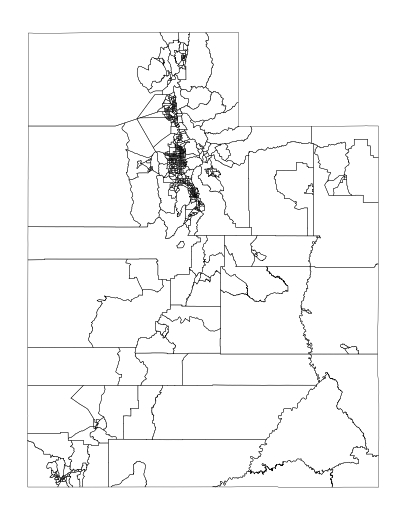

In [17]:
# Plot base layers (census tract and law enforcement) and additional data layers dynamically
def ut_base_df(*layers):
    ax = utct_base_df.boundary.plot(
        figsize=(9,6.5),
        linewidth=0.25,
        edgecolor="000000",
        facecolor='none'
        
    )
    utle_base_df.plot( # Plot the law enforcement map onto Census Tract Map, but make it invisible
        ax=ax,  # Plot this dataframe on top of the boundary plot
        edgecolor="none",
        facecolor="none"
    )
    
    ax.set_axis_off()  
    return ax  # Return the axis to plot further layers on top

plt.show(ut_base_df())

## JOSHUA'S WORK

In [ ]:
# Filtering the AQ Data
air_quality_df = air_quality_df[air_quality_df['State Code'] == 49] # Utah
air_quality_df = air_quality_df[air_quality_df['Parameter Name'] == 'PM2.5 - Local Conditions'] # PM 2.5
air_quality_df = air_quality_df[air_quality_df['Pollutant Standard'].isin(['PM25 24-hour 2024', 'PM25 Annual 2024'])] # PM 2.5 standard effective 2024

In [ ]:
air_quality_df.head()

## Importing the shape file

The shape files can be downloaded from: 
https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html#list-tab-790442341  

We only added the relevant shape file to our GitHub as it would be too large with everything in it. We are using these files:  
* tl_2020_49_tract20.shp
* tl_2020_49_tract20.shx
* tl_2020_49_tract20.dbf
* tl_2020_49_tract20.prj

In [ ]:
# The shape file is in the 'tl_2020_49_all' folder -> tl_2020_49_tract20.shp
# If you want to run, you'll have to replace with your own file path
file_path = "C:/Users/joshu/Documents/GitHub/BMI6016_SDOH/tl_2020_49_all/tl_2020_49_tract20.shp"
census_tracts = gpd.read_file(file_path)

In [ ]:
census_tracts.head()

In [ ]:
print(census_tracts.crs)
# Convert the census_tract GeoDF from EPSG:4269 (NAD83) to EPSG:4326 (WGS 84)
# This will match the format of the geo_df
census_tracts = census_tracts.to_crs(epsg=4326) 
print(census_tracts.crs)

In [ ]:
# Creating point geometries from latitude and longitude

geometry = [Point(xy) for xy in zip(air_quality_df['Longitude'], air_quality_df['Latitude'])]
geo_df = gpd.GeoDataFrame(air_quality_df, geometry=geometry, crs="EPSG:4326")  # The air quality data is in WGS 84 (EPSG:4326)

In [ ]:
# Spatial join between the point GeoDF and census tract DF
joined_df = gpd.sjoin(geo_df, census_tracts, predicate='within', how='left') # Using left join to keep all original data.

In [ ]:
# Extract GEOID from joined GeoDF
if 'GEOID' in joined_df.columns:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'GEOID']]
elif 'GEOID20' in joined_df.columns:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude', 'GEOID20']]
else:
    result_df = joined_df[['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC', 'Latitude', 'Longitude']] # if no GEOID information, keep original data.
    print("Warning: No GEOID or GEOID20 column found in census tract data.")

You can check the census tract by typing in the address to https://geomap.ffiec.gov/ffiecgeomap/

In [ ]:
# Print head of joined_df with unique TRACTCE20 values (unique census tracts)
joined_df.loc[joined_df.drop_duplicates(subset='TRACTCE20').index].head()

In [ ]:
# saving results
#result_df.to_csv("census_tract_results.csv", index=False)